In [ ]:
import torch
import numpy as np
import pandas as pd
import os

from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from pathlib import Path

import CarImageClass

from SSD_from_scratch import mySSD
from SSD_trainer import SSD_train, plot_losses, collate_detection, ConditionalIoUCrop, load_checkpoint, build_optimizer_and_scheduler

device = "cuda" if torch.cuda.is_available() else "cpu"

# set file path
# desktop or laptop
machine = 'desktop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"C:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"

Train model with "bootstrapping".

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 120  |  mAP: 0.4835  |  Train loc loss: 0.1925  |  Train class loss: 0.5337  |  Test loc loss: 0.2246  |  Test class loss: 1.7527
Epoch: 121  |  mAP: 0.4725  |  Train loc loss: 0.1918  |  Train class loss: 0.5337  |  Test loc loss: 0.2302  |  Test class loss: 1.6593
Epoch: 122  |  mAP: 0.4799  |  Train loc loss: 0.1870  |  Train class loss: 0.5224  |  Test loc loss: 0.2247  |  Test class loss: 1.7894
Epoch: 123  |  mAP: 0.4792  |  Train loc loss: 0.1839  |  Train class loss: 0.5120  |  Test loc loss: 0.2251  |  Test class loss: 1.6360
Epoch: 124  |  mAP: 0.4785  |  Train loc loss: 0.1821  |  Train class loss: 0.5073  |  Test loc loss: 0.2163  |  Test class loss: 1.6969
Epoch: 125  |  mAP: 0.4831  |  Train loc loss: 0.1780  |  Train class loss: 0.5027  |  Test loc loss: 0.2155  |  Test class loss: 1.7264
Epoch: 126  |  mAP: 0.4871  |  Train loc loss: 0.1739  |  Train class loss: 0.4930  |  Test loc loss: 0.2137  |  Test class loss: 1.6749
Epoch: 127  |  mAP: 0.4956  |  Train loc 

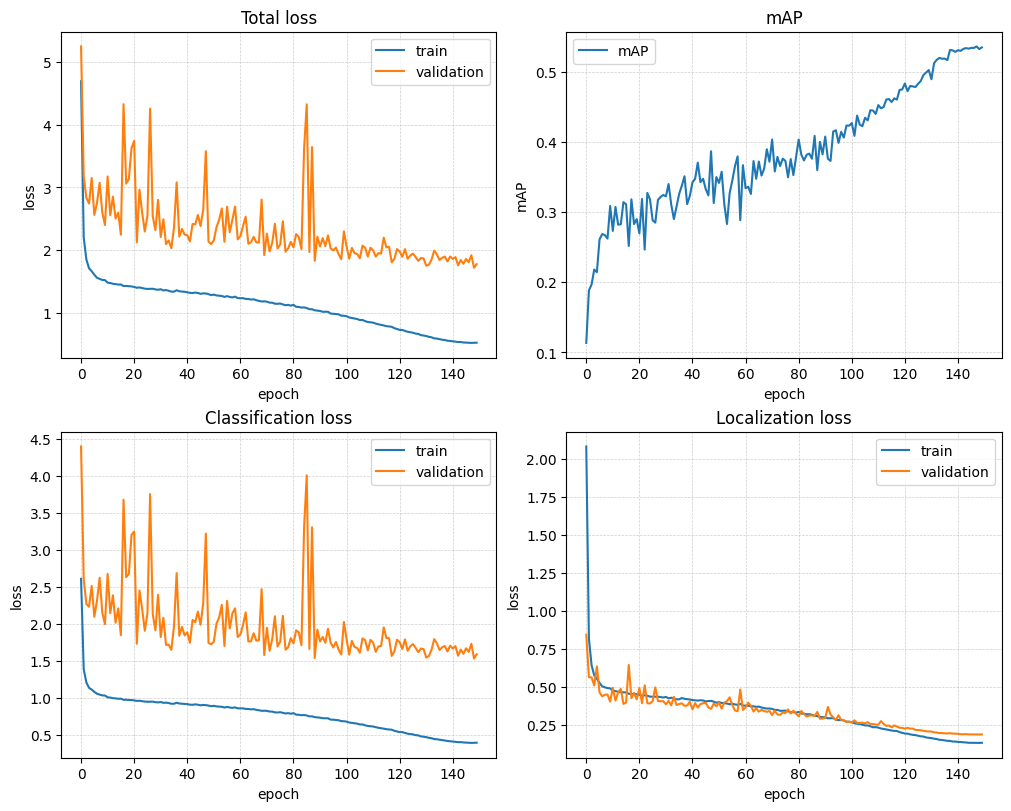

In [ ]:
# transforms
train_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.RandomZoomOut(fill=0, p=0.5),       # Zoom out hurts model performance

    ConditionalIoUCrop(min_area_frac=0.02,   # threshold between "large" and "small"
                       small_min_scale=0.4,
                       large_min_scale=0.7,
                       max_scale=1.0,
                       min_aspect_ratio=0.75,
                       max_aspect_ratio=1.33,
                       small_sampler_options=(0.0, 0.05, 0.1, 2.0),
                       large_sampler_options=(0.05, 0.1, 0.3, 2.0),
                       trials=10),

    v2.SanitizeBoundingBoxes(min_size=1.0),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

# need to put dataloaders on cpu to use pin_memory
train_set = CarImageClass.ImageClass(targ_dir=train_path, transform=train_tfms, file_pct=1, rand_seed=724, include_area=False)

train_data_init, val_data = CarImageClass.make_train_test_split(full_set=train_set,
                                                                test_size=0.25,
                                                                rand_state=724,
                                                                transform_train=train_tfms,
                                                                transform_test=test_tfms,
                                                                include_area=False)

df = train_data_init.annotate_df

# 1) count non-empty objects per filename
obj_counts = (
    df.loc[df["class"] != "empty"]
      .groupby("filename")
      .size()                      # number of rows (objects) per filename
)

# 2) map counts back to all rows, defaulting to 0 when there are no objects
df["num_objects"] = (
    df["filename"]
      .map(obj_counts)            # NaN for filenames with only 'empty'
      .fillna(0)
      .astype(int)
)

filenames0 = df[df['num_objects'] == 0]['filename'].unique().tolist()
filenames12 = df[(df['num_objects'] >= 1) & (df['num_objects'] <= 2)]['filename'].unique().tolist()
filenames36 = df[(df['num_objects'] >= 3) & (df['num_objects'] <= 6)]['filename'].unique().tolist()
filenames79 = df[(df['num_objects'] >= 7) & (df['num_objects'] <= 9)]['filename'].unique().tolist()
filenames10p = df[df['num_objects'] >= 10]['filename'].unique().tolist()

biglist = filenames0 + filenames12 + filenames12 + filenames36 + filenames36 + filenames36 + filenames79 + filenames79 + filenames79 + filenames79 + filenames10p + filenames10p + filenames10p + filenames10p + filenames10p

train_data = CarImageClass.ImageClass(targ_dir=train_path, file_list=biglist, transform=train_tfms, file_pct=1, rand_seed=724, include_area=False)

ssdtestmodel = mySSD(class_to_idx_dict=train_data.class_to_idx, in_channels=3, variances=(0.1, 0.2)).to(device)

del filenames0, filenames12, filenames36, filenames79, filenames10p, biglist, df, train_set


if os.name == "nt":
    torch.multiprocessing.set_start_method("spawn", force=True)
    
BATCH_SIZE = 16
NUM_WORKERS = 8
# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=NUM_WORKERS,
                              persistent_workers=True,
                              prefetch_factor=2,
                              pin_memory=True,
                              collate_fn=collate_detection
                              )

val_dataloader = DataLoader(val_data, 
                            batch_size=BATCH_SIZE, 
                            shuffle=False,
                            num_workers=NUM_WORKERS,
                            persistent_workers=True,
                            prefetch_factor=2,
                            pin_memory=True,
                            collate_fn=collate_detection
                            )

optimizer, scheduler = build_optimizer_and_scheduler(model=ssdtestmodel,
                                                     train_dataloader=train_dataloader,
                                                     max_epochs=150,
                                                     warmup_epochs=5,
                                                     base_lr=0.003,
                                                     min_lr=1e-6,
                                                     momentum=0.9,
                                                     weight_decay=0.005)

resume_path = Path(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models") / "last.ckpt"
if resume_path.exists():
    start_epoch, best_map, loss_dict = load_checkpoint(
        resume_path, ssdtestmodel, optimizer=optimizer, scheduler=scheduler,
        scaler=None, map_location="cpu"  # safe load, then move to device
    )
    ssdtestmodel.to(device)
else:
    start_epoch, best_map, loss_dict = 0, None, None

results = SSD_train(model=ssdtestmodel,
                    train_dataloader=train_dataloader,
                    test_dataloader=val_dataloader,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    sched_step_w_opt=True,
                    iou_thresh=0.4,
                    neg_pos_ratio=3.0,
                    score_thresh=0.2,
                    nms_thresh=0.3,
                    max_detections_per_img=100,
                    epochs=30,
                    early_stopping_rounds=None,
                    device=device,
                    save_model=True,
                    epoch_save_interval=None,
                    SAVE_DIR=r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models",
                    timing=False,
                    past_train_dict=loss_dict,
                    )

plot_losses(results)

Train model without "bootstrapping".

In [ ]:
# transforms
train_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomZoomOut(fill=0, p=0.5),       # Zoom out hurts model performance

    ConditionalIoUCrop(min_area_frac=0.02,   # threshold between "large" and "small"
                       small_min_scale=0.4,
                       large_min_scale=0.7,
                       max_scale=1.0,
                       min_aspect_ratio=0.75,
                       max_aspect_ratio=1.33,
                       small_sampler_options=(0.0, 0.05, 0.1, 2.0),
                       large_sampler_options=(0.05, 0.1, 0.3, 2.0),
                       trials=10),

    v2.SanitizeBoundingBoxes(min_size=1.0),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

# need to put dataloaders on cpu to use pin_memory
train_set = CarImageClass.ImageClass(targ_dir=train_path, transform=train_tfms, file_pct=1, rand_seed=724, include_area=False)
# test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=0.01)

train_data_init, val_data = CarImageClass.make_train_test_split(full_set=train_set,
                                                                test_size=0.25,
                                                                rand_state=724,
                                                                transform_train=train_tfms,
                                                                transform_test=test_tfms,
                                                                include_area=False)

ssdtestmodel = mySSD(class_to_idx_dict=train_data_init.class_to_idx, in_channels=3, variances=(0.1, 0.2)).to(device)

if os.name == "nt":
    torch.multiprocessing.set_start_method("spawn", force=True)
    
BATCH_SIZE = 16
NUM_WORKERS = 8
# Create DataLoader's
train_dataloader = DataLoader(train_data_init, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=NUM_WORKERS,
                              persistent_workers=True,
                              prefetch_factor=2,
                              pin_memory=True,
                              collate_fn=collate_detection
                              )

val_dataloader = DataLoader(val_data, 
                            batch_size=BATCH_SIZE, 
                            shuffle=False,
                            num_workers=NUM_WORKERS,
                            persistent_workers=True,
                            prefetch_factor=2,
                            pin_memory=True,
                            collate_fn=collate_detection
                            )

optimizer, scheduler = build_optimizer_and_scheduler(model=ssdtestmodel,
                                                     train_dataloader=train_dataloader,
                                                     max_epochs=150,
                                                     warmup_epochs=5,
                                                     base_lr=0.003,
                                                     min_lr=1e-6,
                                                     momentum=0.9,
                                                     weight_decay=0.005)

resume_path = Path(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models") / "last.ckpt"
if resume_path.exists():
    start_epoch, best_map, loss_dict = load_checkpoint(
        resume_path, ssdtestmodel, optimizer=optimizer, scheduler=scheduler,
        scaler=None, map_location="cpu"  # safe load, then move to device
    )
    ssdtestmodel.to(device)
else:
    start_epoch, best_map, loss_dict = 0, None, None

results = SSD_train(model=ssdtestmodel,
                    train_dataloader=train_dataloader,
                    test_dataloader=val_dataloader,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    sched_step_w_opt=True,
                    iou_thresh=0.4,
                    neg_pos_ratio=3.0,
                    score_thresh=0.2,
                    nms_thresh=0.3,
                    max_detections_per_img=100,
                    epochs=150,
                    early_stopping_rounds=None,
                    device=device,
                    save_model=True,
                    epoch_save_interval=None,
                    SAVE_DIR=r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models",
                    timing=False,
                    past_train_dict=loss_dict,
                    )

plot_losses(results)

Load a model and view some predictions!

In [3]:
ssd_model = mySSD(class_to_idx_dict={'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4},
                  in_channels=3,
                  variances=(0.1, 0.2))

ssd_model.to(device='cpu')

WEIGHTS_PATH = r"C:\Users\eblac\Documents\GitHub\self-driving-car\app_files\saved_models\noZoomOut_Bootstrap.pth"
state_dict = torch.load(WEIGHTS_PATH, map_location="cpu", weights_only=False)
missing, unexpected = ssd_model.load_state_dict(state_dict, strict=False)
print("missing:", missing)
print("unexpected:", unexpected)

missing: []
unexpected: []


In [6]:
# List containing test images
test_list = list(Path(test_path).glob("*.jpg"))

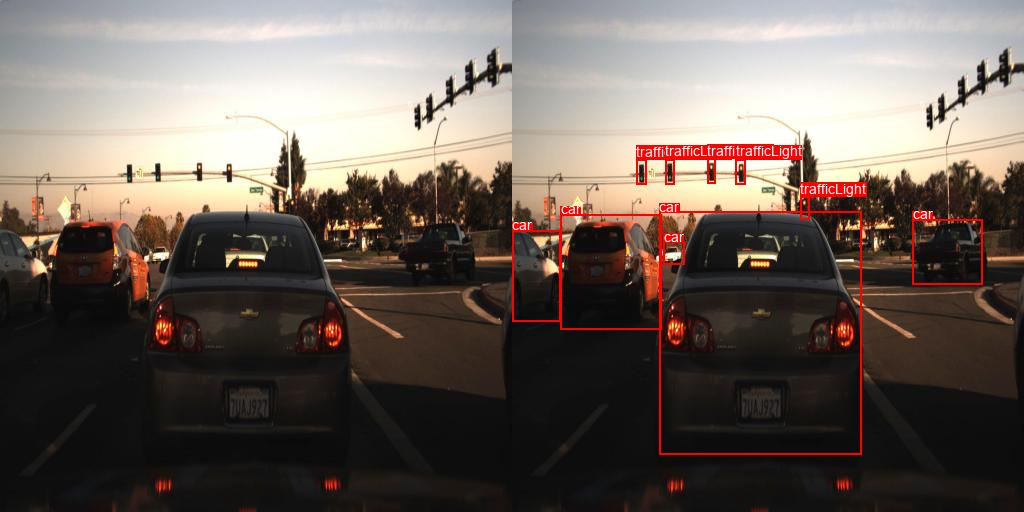

In [14]:
# View some predictions
rand_idx = np.random.randint(0, len(test_list))

ssd_model.show_prediction_side_by_side(image_path=test_list[rand_idx],
                                       pil_img=None,
                                       score_thresh=0.2,
                                       nms_thresh=0.3,
                                       max_per_img=200,
                                       class_agnostic=False,
                                       target_height=512)

Compute mAP@0.50 for three models:

In [ ]:
ssd_model_ZO_noBS = mySSD(class_to_idx_dict={'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4},
                          in_channels=3,
                          variances=(0.1, 0.2))
ssd_model_noZO_noBS = mySSD(class_to_idx_dict={'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4},
                            in_channels=3,
                            variances=(0.1, 0.2))
ssd_model_noZO_BS = mySSD(class_to_idx_dict={'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4},
                          in_channels=3,
                          variances=(0.1, 0.2))

WEIGHTS_PATH = r"C:\Users\eblac\Documents\GitHub\self-driving-car\app_files\saved_models\ZoomOut_noBootstrap.pth"
state_dict = torch.load(WEIGHTS_PATH, map_location="cpu", weights_only=False)
ssd_model_ZO_noBS.load_state_dict(state_dict, strict=False)
ssd_model_ZO_noBS.to(device=device)

WEIGHTS_PATH = r"C:\Users\eblac\Documents\GitHub\self-driving-car\app_files\saved_models\noZoomOut_noBootstrap.pth"
state_dict = torch.load(WEIGHTS_PATH, map_location="cpu", weights_only=False)
ssd_model_noZO_noBS.load_state_dict(state_dict, strict=False)
ssd_model_noZO_noBS.to(device=device)

WEIGHTS_PATH = r"C:\Users\eblac\Documents\GitHub\self-driving-car\app_files\saved_models\noZoomOut_Bootstrap.pth"
state_dict = torch.load(WEIGHTS_PATH, map_location="cpu", weights_only=False)
ssd_model_noZO_BS.load_state_dict(state_dict, strict=False)
ssd_model_noZO_BS.to(device=device)


test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=1)

test_dataloader = DataLoader(test_data, 
                             batch_size=16, 
                             shuffle=False, 
                             num_workers=8,
                             persistent_workers=True,
                             prefetch_factor=2,
                             pin_memory=False,
                             collate_fn=collate_detection
                             )

map_metric_ZO_noBS = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[0.50], class_metrics=True).to(device)
map_metric_noZO_noBS = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[0.50], class_metrics=True).to(device)
map_metric_noZO_BS = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[0.50], class_metrics=True).to(device)
map_metric_ZO_noBS.reset()
map_metric_noZO_noBS.reset()
map_metric_noZO_BS.reset()

for images, targets in test_dataloader:
    preds_ZO_noBS = ssd_model_ZO_noBS.predict(images.to(device), score_thresh=0.2, nms_thresh=0.3, max_per_img=100)     # list[dict] per image
    preds_noZO_noBS = ssd_model_noZO_noBS.predict(images.to(device), score_thresh=0.2, nms_thresh=0.3, max_per_img=100)
    preds_noZO_BS = ssd_model_noZO_BS.predict(images.to(device), score_thresh=0.2, nms_thresh=0.3, max_per_img=100)
    # ensure preds/targets tensors are on `device` and labels are 0..C-1
    for i in range(len(targets)):
        for key in targets[i].keys():
            targets[i][key] = targets[i][key].to(device)
    
    map_metric_ZO_noBS.update(preds=preds_ZO_noBS, target=targets)
    map_metric_noZO_noBS.update(preds=preds_noZO_noBS, target=targets)
    map_metric_noZO_BS.update(preds=preds_noZO_BS, target=targets)

mAP_test_results_ZO_noBS = map_metric_ZO_noBS.compute()
mAP_test_results_noZO_noBS = map_metric_noZO_noBS.compute()
mAP_test_results_noZO_BS = map_metric_noZO_BS.compute()

print()
print(mAP_test_results_ZO_noBS)
print()
print(mAP_test_results_noZO_noBS)
print()
print(mAP_test_results_noZO_BS)


{'map': tensor(0.4613), 'map_50': tensor(0.4613), 'map_75': tensor(-1.), 'map_small': tensor(0.3816), 'map_medium': tensor(0.8154), 'map_large': tensor(0.7936), 'mar_1': tensor(0.2667), 'mar_10': tensor(0.5169), 'mar_100': tensor(0.5180), 'mar_small': tensor(0.4461), 'mar_medium': tensor(0.8495), 'mar_large': tensor(0.7997), 'map_per_class': tensor([0.2854, 0.6618, 0.2145, 0.5571, 0.5875]), 'mar_100_per_class': tensor([0.3397, 0.7056, 0.3021, 0.6127, 0.6299]), 'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)}

{'map': tensor(0.4724), 'map_50': tensor(0.4724), 'map_75': tensor(-1.), 'map_small': tensor(0.3901), 'map_medium': tensor(0.8247), 'map_large': tensor(0.9411), 'mar_1': tensor(0.2719), 'mar_10': tensor(0.5237), 'mar_100': tensor(0.5248), 'mar_small': tensor(0.4515), 'mar_medium': tensor(0.8554), 'mar_large': tensor(0.9485), 'map_per_class': tensor([0.3015, 0.6681, 0.2314, 0.5619, 0.5992]), 'mar_100_per_class': tensor([0.3587, 0.7053, 0.3225, 0.6125, 0.6247]), 'classes': te